In [ ]:
# ============================================================================
# TRANSFORMER-BASED SENTIMENT ANALYSIS USING DISTILBERT
# Faculty Presentation - Google Colab Notebook
# ============================================================================

# ============================================================================
# CELL 1: INSTALL & IMPORT PACKAGES
# ============================================================================

# Install required packages
!pip install -q transformers datasets torch scikit-learn

# Import libraries
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# HuggingFace libraries
from transformers import (
    DistilBertTokenizer,
    DistilBertForSequenceClassification,
    TrainingArguments,
    Trainer
)
from datasets import Dataset

# Set random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Check GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
else:
    print("GPU not available. Training will be slower.")
    print("To enable GPU: Runtime → Change runtime type → GPU")

print("\n✓ All packages imported successfully!")

# ============================================================================
# CELL 2: UPLOAD DATASET
# ============================================================================

from google.colab import files

# Upload CSV file
print("Please upload your sentiment analysis CSV file...")
uploaded = files.upload()

# Get filename
filename = list(uploaded.keys())[0]
print(f"\n✓ File uploaded: {filename}")

# Load dataset
df = pd.read_csv(filename, encoding='latin-1')
print(f"✓ Dataset loaded: {df.shape[0]} rows, {df.shape[1]} columns")
print(f"\nFirst 5 rows:")
display(df.head())

# ============================================================================
# CELL 3: DATA PREPROCESSING
# ============================================================================

print("Starting data preprocessing...")

# Check for required columns
if 'text' not in df.columns or 'sentiment' not in df.columns:
    # If columns have different names, rename them
    # Assuming first text column is 'text' and sentiment column exists
    if 'text' not in df.columns:
        # Find the text column (usually contains actual text)
        text_col = [col for col in df.columns if 'text' in col.lower()][0]
        df.rename(columns={text_col: 'text'}, inplace=True)

# Remove null values
print(f"Rows before removing nulls: {len(df)}")
df = df.dropna(subset=['text', 'sentiment'])
print(f"Rows after removing nulls: {len(df)}")

# Keep only text and sentiment columns
df = df[['text', 'sentiment']].copy()

# Encode sentiment labels to numeric values
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['sentiment'])

# Display label mapping
print("\n✓ Label Encoding:")
for i, sentiment in enumerate(label_encoder.classes_):
    print(f"  {sentiment} → {i}")

# Display sentiment distribution
print("\n✓ Sentiment Distribution:")
print(df['sentiment'].value_counts())

# Split into train and test sets (80/20)
train_df, test_df = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    stratify=df['label']
)

print(f"\n✓ Data Split:")
print(f"  Training samples: {len(train_df)}")
print(f"  Test samples: {len(test_df)}")

print("\n✓ Preprocessing complete!")

# ============================================================================
# CELL 4: MODEL SETUP
# ============================================================================

print("Setting up DistilBERT model...")

# Load DistilBERT tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
print("✓ Tokenizer loaded")

# Load DistilBERT model for classification
num_labels = len(label_encoder.classes_)
model = DistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-uncased',
    num_labels=num_labels
)
print(f"✓ Model loaded with {num_labels} output labels")

# Tokenization function
def tokenize_function(examples):
    return tokenizer(
        examples['text'],
        padding='max_length',
        truncation=True,
        max_length=128
    )

# Convert to HuggingFace Dataset format
train_dataset = Dataset.from_pandas(train_df[['text', 'label']])
test_dataset = Dataset.from_pandas(test_df[['text', 'label']])

# Tokenize datasets
print("\n✓ Tokenizing datasets...")
train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

# Set format for PyTorch
train_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
test_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

print("✓ Datasets tokenized and ready for training")

# Define metrics computation function
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    accuracy = accuracy_score(labels, predictions)
    return {'accuracy': accuracy}

print("\n✓ Model setup complete!")

# ============================================================================
# CELL 5: TRAINING
# ============================================================================

print("Starting model training...")
print("This may take 5-15 minutes depending on dataset size and GPU availability.")
print("-" * 70)

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy='epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_steps=50,
    save_strategy='epoch',
    load_best_model_at_end=True,
    metric_for_best_model='accuracy',
)

# Create Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

# Train the model
trainer.train()

print("\n✓ Training complete!")

# ============================================================================
# CELL 6: EVALUATION
# ============================================================================

print("Evaluating model on test set...")
print("-" * 70)

# Evaluate on test set
results = trainer.evaluate(test_dataset)

# Print results
print("\n📊 TEST SET RESULTS")
print("=" * 70)
print(f"Accuracy: {results['eval_accuracy']:.4f} ({results['eval_accuracy']*100:.2f}%)")
print("=" * 70)

# Get predictions for confusion matrix
predictions_output = trainer.predict(test_dataset)
predictions = np.argmax(predictions_output.predictions, axis=1)
true_labels = test_df['label'].values

print("\n✓ Evaluation complete!")

# ============================================================================
# CELL 7: CONFUSION MATRIX
# ============================================================================

print("Generating confusion matrix...")

# Compute confusion matrix
cm = confusion_matrix(true_labels, predictions)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=label_encoder.classes_,
    yticklabels=label_encoder.classes_,
    cbar_kws={'label': 'Count'}
)
plt.title('Confusion Matrix - DistilBERT Sentiment Analysis',
          fontsize=14, fontweight='bold', pad=20)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.show()

print("\n✓ Confusion matrix displayed!")

# ============================================================================
# CELL 8: PREDICTION FUNCTION & DEMO
# ============================================================================

print("Creating prediction function...")

# Move model to CPU for inference (more compatible)
model.to('cpu')
model.eval()

def predict(text):
    """
    Predict sentiment for a given text

    Args:
        text (str): Input text to analyze

    Returns:
        str: Predicted sentiment label
    """
    # Tokenize input text
    inputs = tokenizer(
        text,
        padding='max_length',
        truncation=True,
        max_length=128,
        return_tensors='pt'
    )

    # Get prediction
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        predicted_class = torch.argmax(logits, dim=1).item()

    # Convert to sentiment label
    sentiment = label_encoder.inverse_transform([predicted_class])[0]

    return sentiment

print("✓ Prediction function created!")

# ============================================================================
# DEMO: EXAMPLE PREDICTIONS
# ============================================================================

print("\n" + "=" * 70)
print("EXAMPLE PREDICTIONS")
print("=" * 70)

# Example texts
example_texts = [
    "This product is absolutely amazing! I love it!",
    "Worst purchase ever. Completely disappointed.",
    "It's okay, nothing special but works fine."
]

# Make predictions
for i, text in enumerate(example_texts, 1):
    predicted_sentiment = predict(text)
    print(f"\n{i}. Text: \"{text}\"")
    print(f"   Predicted Sentiment: {predicted_sentiment}")

print("\n" + "=" * 70)
print("✅ SENTIMENT ANALYSIS MODEL READY!")
print("=" * 70)
print(f"\nModel: DistilBERT (distilbert-base-uncased)")
print(f"Test Accuracy: {results['eval_accuracy']:.4f}")
print(f"Number of classes: {num_labels}")
print(f"\nYou can now use the predict() function to analyze any text:")
print("  sentiment = predict('Your text here')")
print("=" * 70)

Using device: cuda
GPU: Tesla T4

✓ All packages imported successfully!
Please upload your sentiment analysis CSV file...


Saving train.csv to train (1).csv

✓ File uploaded: train (1).csv
✓ Dataset loaded: 27481 rows, 10 columns

First 5 rows:


,textID,text,selected_text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²)
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,morning,0-20,Afghanistan,38928346,652860.0,60
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,noon,21-30,Albania,2877797,27400.0,105
2,088c60f138,my boss is bullying me...,bullying me,negative,night,31-45,Algeria,43851044,2381740.0,18
3,9642c003ef,what interview! leave me alone,leave me alone,negative,morning,46-60,Andorra,77265,470.0,164
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,noon,60-70,Angola,32866272,1246700.0,26


Starting data preprocessing...
Rows before removing nulls: 27481
Rows after removing nulls: 27480

✓ Label Encoding:
  negative → 0
  neutral → 1
  positive → 2

✓ Sentiment Distribution:
sentiment
neutral     11117
positive     8582
negative     7781
Name: count, dtype: int64

✓ Data Split:
  Training samples: 21984
  Test samples: 5496

✓ Preprocessing complete!
Setting up DistilBERT model...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

✓ Tokenizer loaded


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

DistilBertForSequenceClassification LOAD REPORT from: distilbert-base-uncased
Key                     | Status     | 
------------------------+------------+-
vocab_transform.bias    | UNEXPECTED | 
vocab_layer_norm.weight | UNEXPECTED | 
vocab_projector.bias    | UNEXPECTED | 
vocab_transform.weight  | UNEXPECTED | 
vocab_layer_norm.bias   | UNEXPECTED | 
pre_classifier.weight   | MISSING    | 
pre_classifier.bias     | MISSING    | 
classifier.weight       | MISSING    | 
classifier.bias         | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


✓ Model loaded with 3 output labels

✓ Tokenizing datasets...


Map:   0%|          | 0/21984 [00:00<?, ? examples/s]

Map:   0%|          | 0/5496 [00:00<?, ? examples/s]

✓ Datasets tokenized and ready for training

✓ Model setup complete!
Starting model training...
This may take 5-15 minutes depending on dataset size and GPU availability.
----------------------------------------------------------------------


TypeError: TrainingArguments.__init__() got an unexpected keyword argument 'evaluation_strategy'

Using device: cuda
GPU: Tesla T4

✓ All packages imported successfully!
Please upload your sentiment analysis CSV file...


Saving train.csv to train (2).csv

✓ File uploaded: train (2).csv
✓ Dataset loaded: 27481 rows, 10 columns

First 5 rows:


,textID,text,selected_text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²)
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,morning,0-20,Afghanistan,38928346,652860.0,60
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,noon,21-30,Albania,2877797,27400.0,105
2,088c60f138,my boss is bullying me...,bullying me,negative,night,31-45,Algeria,43851044,2381740.0,18
3,9642c003ef,what interview! leave me alone,leave me alone,negative,morning,46-60,Andorra,77265,470.0,164
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,noon,60-70,Angola,32866272,1246700.0,26


Starting data preprocessing...
Rows before removing nulls: 27481
Rows after removing nulls: 27480

✓ Label Encoding:
  negative → 0
  neutral → 1
  positive → 2

✓ Sentiment Distribution:
sentiment
neutral     11117
positive     8582
negative     7781
Name: count, dtype: int64

✓ Data Split:
  Training samples: 21984
  Test samples: 5496

✓ Preprocessing complete!
Setting up DistilBERT model...
✓ Tokenizer loaded


Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

DistilBertForSequenceClassification LOAD REPORT from: distilbert-base-uncased
Key                     | Status     | 
------------------------+------------+-
vocab_transform.bias    | UNEXPECTED | 
vocab_layer_norm.weight | UNEXPECTED | 
vocab_projector.bias    | UNEXPECTED | 
vocab_transform.weight  | UNEXPECTED | 
vocab_layer_norm.bias   | UNEXPECTED | 
pre_classifier.weight   | MISSING    | 
pre_classifier.bias     | MISSING    | 
classifier.weight       | MISSING    | 
classifier.bias         | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


✓ Model loaded with 3 output labels

✓ Tokenizing datasets...


Map:   0%|          | 0/21984 [00:00<?, ? examples/s]

Map:   0%|          | 0/5496 [00:00<?, ? examples/s]

✓ Datasets tokenized and ready for training

✓ Model setup complete!
Starting model training...
This may take 5-15 minutes depending on dataset size and GPU availability.
----------------------------------------------------------------------


Epoch,Training Loss,Validation Loss,Accuracy
1,0.523133,0.535412,0.782751
2,0.442250,0.538029,0.794942
3,0.325803,0.586006,0.794942


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

There were missing keys in the checkpoint model loaded: ['distilbert.embeddings.LayerNorm.weight', 'distilbert.embeddings.LayerNorm.bias'].
There were unexpected keys in the checkpoint model loaded: ['distilbert.embeddings.LayerNorm.beta', 'distilbert.embeddings.LayerNorm.gamma'].



✓ Training complete!
Evaluating model on test set...
----------------------------------------------------------------------



📊 TEST SET RESULTS
Accuracy: 0.7949 (79.49%)

✓ Evaluation complete!
Generating confusion matrix...


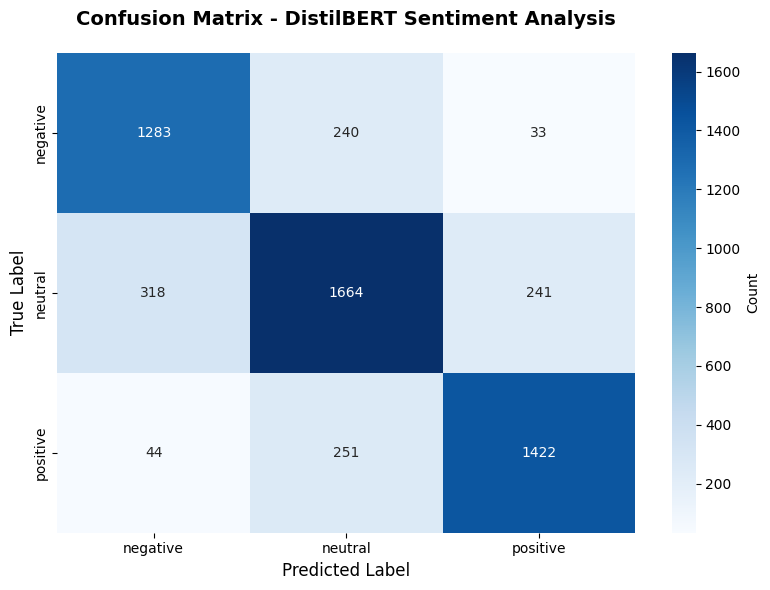


✓ Confusion matrix displayed!
Creating prediction function...
✓ Prediction function created!

EXAMPLE PREDICTIONS

1. Text: "This product is absolutely amazing! I love it!"
   Predicted Sentiment: positive

2. Text: "Worst purchase ever. Completely disappointed."
   Predicted Sentiment: negative

3. Text: "It's okay, nothing special but works fine."
   Predicted Sentiment: positive

✅ SENTIMENT ANALYSIS MODEL READY!

Model: DistilBERT (distilbert-base-uncased)
Test Accuracy: 0.7949
Number of classes: 3

You can now use the predict() function to analyze any text:
  sentiment = predict('Your text here')


In [ ]:
# ============================================================================
# TRANSFORMER-BASED SENTIMENT ANALYSIS USING DISTILBERT
# Faculty Presentation - Google Colab Notebook
# ============================================================================

# ============================================================================
# CELL 1: INSTALL & IMPORT PACKAGES
# ============================================================================

# Install required packages
!pip install -q transformers datasets torch scikit-learn

# Import libraries
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# HuggingFace libraries
from transformers import (
    DistilBertTokenizer,
    DistilBertForSequenceClassification,
    TrainingArguments,
    Trainer
)
from datasets import Dataset

# Set random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Check GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
else:
    print("GPU not available. Training will be slower.")
    print("To enable GPU: Runtime → Change runtime type → GPU")

print("\n✓ All packages imported successfully!")

# ============================================================================
# CELL 2: UPLOAD DATASET
# ============================================================================

from google.colab import files

# Upload CSV file
print("Please upload your sentiment analysis CSV file...")
uploaded = files.upload()

# Get filename
filename = list(uploaded.keys())[0]
print(f"\n✓ File uploaded: {filename}")

# Load dataset
df = pd.read_csv(filename, encoding='latin-1')
print(f"✓ Dataset loaded: {df.shape[0]} rows, {df.shape[1]} columns")
print(f"\nFirst 5 rows:")
display(df.head())

# ============================================================================
# CELL 3: DATA PREPROCESSING
# ============================================================================

print("Starting data preprocessing...")

# Check for required columns
if 'text' not in df.columns or 'sentiment' not in df.columns:
    # If columns have different names, rename them
    # Assuming first text column is 'text' and sentiment column exists
    if 'text' not in df.columns:
        # Find the text column (usually contains actual text)
        text_col = [col for col in df.columns if 'text' in col.lower()][0]
        df.rename(columns={text_col: 'text'}, inplace=True)

# Remove null values
print(f"Rows before removing nulls: {len(df)}")
df = df.dropna(subset=['text', 'sentiment'])
print(f"Rows after removing nulls: {len(df)}")

# Keep only text and sentiment columns
df = df[['text', 'sentiment']].copy()

# Encode sentiment labels to numeric values
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['sentiment'])

# Display label mapping
print("\n✓ Label Encoding:")
for i, sentiment in enumerate(label_encoder.classes_):
    print(f"  {sentiment} → {i}")

# Display sentiment distribution
print("\n✓ Sentiment Distribution:")
print(df['sentiment'].value_counts())

# Split into train and test sets (80/20)
train_df, test_df = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    stratify=df['label']
)

print(f"\n✓ Data Split:")
print(f"  Training samples: {len(train_df)}")
print(f"  Test samples: {len(test_df)}")

print("\n✓ Preprocessing complete!")

# ============================================================================
# CELL 4: MODEL SETUP
# ============================================================================

print("Setting up DistilBERT model...")

# Load DistilBERT tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
print("✓ Tokenizer loaded")

# Load DistilBERT model for classification
num_labels = len(label_encoder.classes_)
model = DistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-uncased',
    num_labels=num_labels
)
print(f"✓ Model loaded with {num_labels} output labels")

# Tokenization function
def tokenize_function(examples):
    return tokenizer(
        examples['text'],
        padding='max_length',
        truncation=True,
        max_length=128
    )

# Convert to HuggingFace Dataset format
train_dataset = Dataset.from_pandas(train_df[['text', 'label']])
test_dataset = Dataset.from_pandas(test_df[['text', 'label']])

# Tokenize datasets
print("\n✓ Tokenizing datasets...")
train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

# Set format for PyTorch
train_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
test_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

print("✓ Datasets tokenized and ready for training")

# Define metrics computation function
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    accuracy = accuracy_score(labels, predictions)
    return {'accuracy': accuracy}

print("\n✓ Model setup complete!")

# ============================================================================
# CELL 5: TRAINING
# ============================================================================

print("Starting model training...")
print("This may take 5-15 minutes depending on dataset size and GPU availability.")
print("-" * 70)

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    eval_strategy='epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_steps=50,
    save_strategy='epoch',
    load_best_model_at_end=True,
    metric_for_best_model='accuracy',
)

# Create Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

# Train the model
trainer.train()

print("\n✓ Training complete!")

# ============================================================================
# CELL 6: EVALUATION
# ============================================================================

print("Evaluating model on test set...")
print("-" * 70)

# Evaluate on test set
results = trainer.evaluate(test_dataset)

# Print results
print("\n📊 TEST SET RESULTS")
print("=" * 70)
print(f"Accuracy: {results['eval_accuracy']:.4f} ({results['eval_accuracy']*100:.2f}%)")
print("=" * 70)

# Get predictions for confusion matrix
predictions_output = trainer.predict(test_dataset)
predictions = np.argmax(predictions_output.predictions, axis=1)
true_labels = test_df['label'].values

print("\n✓ Evaluation complete!")

# ============================================================================
# CELL 7: CONFUSION MATRIX
# ============================================================================

print("Generating confusion matrix...")

# Compute confusion matrix
cm = confusion_matrix(true_labels, predictions)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=label_encoder.classes_,
    yticklabels=label_encoder.classes_,
    cbar_kws={'label': 'Count'}
)
plt.title('Confusion Matrix - DistilBERT Sentiment Analysis',
          fontsize=14, fontweight='bold', pad=20)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.show()

print("\n✓ Confusion matrix displayed!")

# ============================================================================
# CELL 8: PREDICTION FUNCTION & DEMO
# ============================================================================

print("Creating prediction function...")

# Move model to CPU for inference (more compatible)
model.to('cpu')
model.eval()

def predict(text):
    """
    Predict sentiment for a given text

    Args:
        text (str): Input text to analyze

    Returns:
        str: Predicted sentiment label
    """
    # Tokenize input text
    inputs = tokenizer(
        text,
        padding='max_length',
        truncation=True,
        max_length=128,
        return_tensors='pt'
    )

    # Get prediction
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        predicted_class = torch.argmax(logits, dim=1).item()

    # Convert to sentiment label
    sentiment = label_encoder.inverse_transform([predicted_class])[0]

    return sentiment

print("✓ Prediction function created!")

# ============================================================================
# DEMO: EXAMPLE PREDICTIONS
# ============================================================================

print("\n" + "=" * 70)
print("EXAMPLE PREDICTIONS")
print("=" * 70)

# Example texts
example_texts = [
    "This product is absolutely amazing! I love it!",
    "Worst purchase ever. Completely disappointed.",
    "It's okay, nothing special but works fine."
]

# Make predictions
for i, text in enumerate(example_texts, 1):
    predicted_sentiment = predict(text)
    print(f"\n{i}. Text: \"{text}\"")
    print(f"   Predicted Sentiment: {predicted_sentiment}")

print("\n" + "=" * 70)
print("✅ SENTIMENT ANALYSIS MODEL READY!")
print("=" * 70)
print(f"\nModel: DistilBERT (distilbert-base-uncased)")
print(f"Test Accuracy: {results['eval_accuracy']:.4f}")
print(f"Number of classes: {num_labels}")
print(f"\nYou can now use the predict() function to analyze any text:")
print("  sentiment = predict('Your text here')")
print("=" * 70)

In [7]:
# Interactive input
user_input = input("Enter a sentence to analyze sentiment: ")

prediction = predict(user_input)

print("\nPrediction Result:")
print("Sentiment:", prediction)


Enter a sentence to analyze sentiment: i dont want to play cricket

Prediction Result:
Sentiment: negative
